In [41]:
from __future__ import division, print_function
import copy

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import lmfit
from kid_readout.measurement import plot_basic
from kid_readout.measurement.io import npy
from kid_readout.analysis.resonator import lmfit_resonator

In [2]:
npd = npy.NumpyDirectory('/Users/daniel/Dropbox/ColumbiaCMB/data/chosen_one.npd')

In [3]:
npd.node_names()

['SingleSweepStream0']

In [4]:
chosen_mod = npd.SingleSweepStream0

In [5]:
chosen_mod.sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [6]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

In [7]:
print("resonance frequency is {:.1f} MHz".format(1e-6 * chosen_mod.resonator.f_0))
print("internal loss is {:.3g} = 1 / {:.3g}".format(chosen_mod.resonator.loss_i, 1 / chosen_mod.resonator.loss_i))
print("coupling loss is {:.3g} = 1 / {:.3g}".format(chosen_mod.resonator.loss_c, 1 / chosen_mod.resonator.loss_c))

resonance frequency is 3409.7 MHz
internal loss is 8.14e-05 = 1 / 1.23e+04
coupling loss is 1.92e-05 = 1 / 5.22e+04


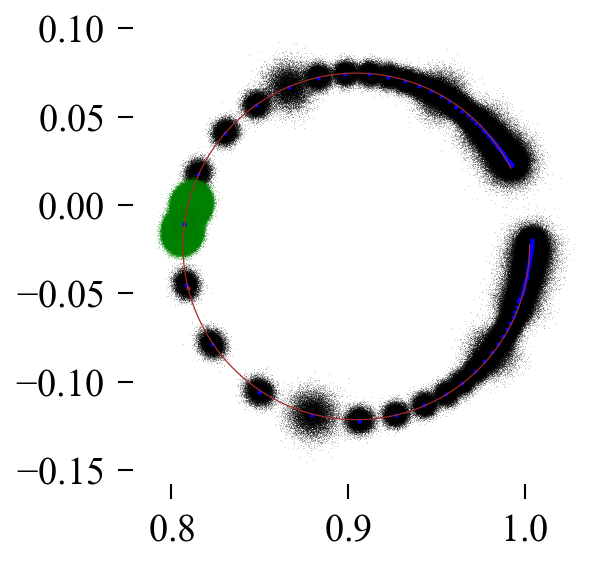

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot_basic.sss_complex_plane(axis=ax, sss=chosen_mod)

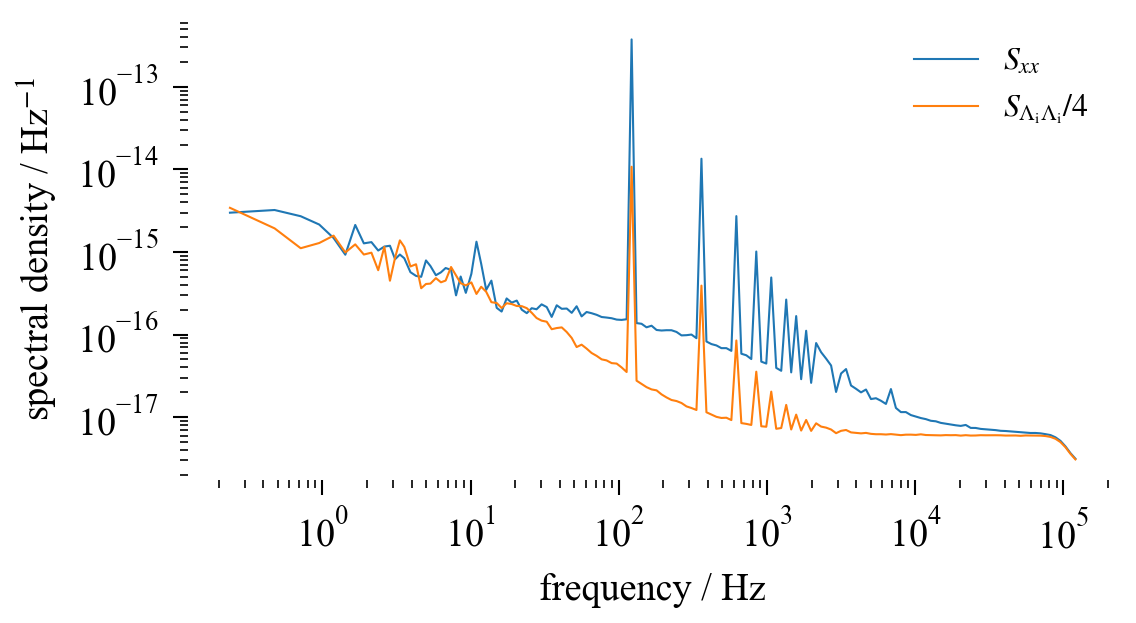

In [9]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('spectral density / Hz$^{-1}$')    
ax.plot(chosen_mod.S_frequency, chosen_mod.S_xx,
        linestyle='-', label='$S_{xx}$')
ax.plot(chosen_mod.S_frequency, chosen_mod.S_yy,
        linestyle='-', label='$S_{\Lambda_\mathrm{i} \Lambda_\mathrm{i}} / 4$'),
ax.legend(fontsize='x-small')

# Chopped data

In [10]:
# The automatic folding doesn't calculate the period samples correctly for this build
print(chosen_mod.stream.stream_sample_rate / 2**11)

x_fold = chosen_mod.fold(chosen_mod.x, period_samples=2**11)
num_samples = x_fold.size
x_fold = np.roll(x_fold, num_samples // 2)
time_fold = chosen_mod.stream.sample_time[:num_samples]
x_fold_rise = x_fold[:num_samples // 2]
time_fold_rise = time_fold[:num_samples // 2]
x_fold_fall = x_fold[num_samples // 2:]
time_fold_fall = time_fold[num_samples // 2 :]

122.0703125


In [11]:
np.argmax(x_fold_rise)

241

In [12]:
time_scale = 1e3
x_scale = 1e6

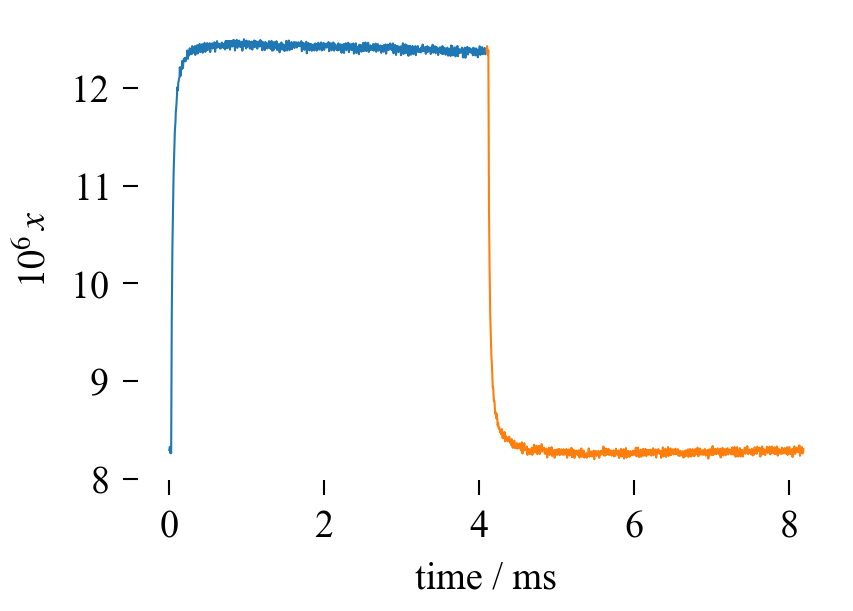

In [13]:
fig, ax = plt.subplots()
ax.set_ylabel('$10^6 \, x$')
ax.set_xlabel('time / ms')
#ax.plot(time_scale * time_fold, x_scale * x_fold)
ax.plot(time_scale * time_fold_rise, x_scale * x_fold_rise)
ax.plot(time_scale * time_fold_fall, x_scale * x_fold_fall)

(0, 0.05)

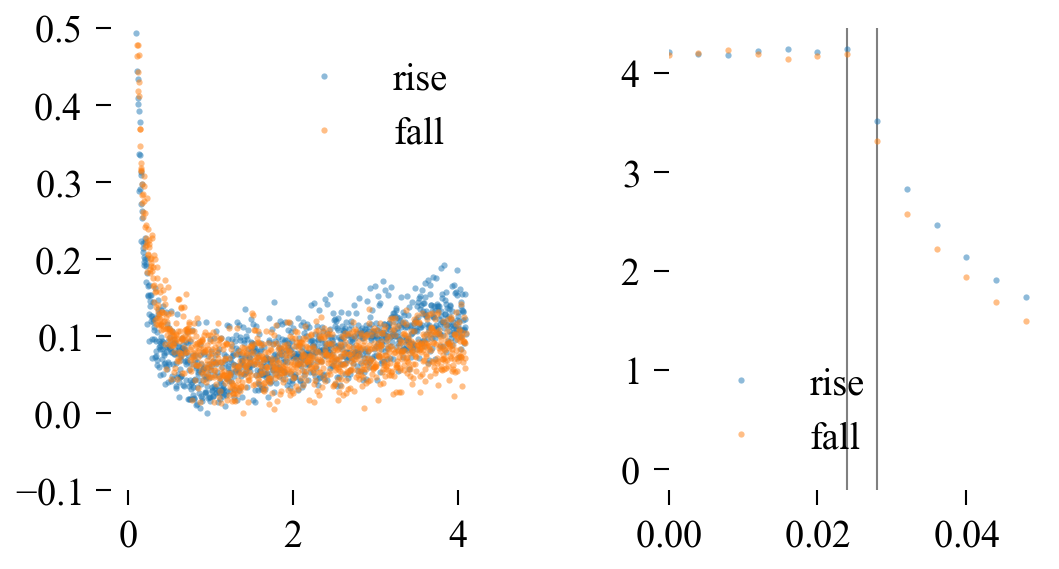

In [14]:
fig, (ax_full, ax_detail) = plt.subplots(1, 2, figsize=(4, 2), gridspec_kw={'wspace': 0.5})
ax_detail.axvline(time_scale * time_fold_rise[6], color='gray')
ax_detail.axvline(time_scale * time_fold_rise[7], color='gray')
for ax in (ax_full, ax_detail):
    ax.plot(time_scale * time_fold_rise,
            x_scale * (x_fold_rise.max() - x_fold_rise),
            '.', label='rise', alpha=0.5)
    ax.plot(time_scale * (time_fold_fall - time_fold_fall.min()),
                          x_scale * (x_fold_fall - x_fold_fall.min()),
                          '.', label='fall', alpha=0.5)
    ax.legend()
    
#ax_full.set_yscale('log')
ax_full.set_ylim(-0.1, 0.5)
ax_detail.set_xlim(0, 0.05)


In [39]:
def old_delta_x(t, t0, xbar, dx0, R_dn0, tau):
    x = np.zeros(t.size)
    x[t < t0] = xbar + dx0
    dx = dx0 / (1 + (1 + R_dn0 * tau) * (np.exp((t - t0) / tau) - 1))
    x[t >= t0] = xbar + dx[t >= t0]
    return x


def dn(t, dn0, n_bar, R, S=0):
    tau = (2 * R * nbar)**-1
    return dn0 / (1 + (1 + 2 * n_bar * S / R) * (np.exp(t / tau) - 1))


def n_one_period(t, t_lag, n_low, n_high, R, S=0):
    tau_rise = 1 / (2 * R * n_high)
    tau_fall = 1 / (2 * R * n_low)
    t_half = t.ptp() / 2
    rise = t < t_half
    fall = t_half <= t
    x = np.concatenate((dx_decay(t=t_rise, xbar=xlow + dx0, dx0=-dx0, R_dn0_tau=R_dn0_tau, tau=tau),
                        dx_decay(t=t_fall, xbar=xlow, dx0=dx0, R_dn0_tau=R_dn0_tau, tau=tau)))
    
    

def dx_decay(t, t0, xbar, dx0, R_dn0_tau, tau):
    return xbar + dx0 / (1 + (1 + R_dn0_tau) * (np.exp((t - t0) / tau) - 1))
    
model = lmfit.Model(dx_decay) #, independent_vars=['t', 'xbar', 'dx0'])

def fit(x, t, last_before_decay=6, last_after_decay=250, num_averaged=6, params=None):
    t_fit = t[last_before_decay + 1:last_after_decay]
    x_fit = x[last_before_decay + 1:last_after_decay]
    xbar = x_fit[-num_averaged:].mean()
    #dx0 = x[:num_averaged].mean() - xbar
    dx0 = x_fit[0] - xbar
    guess = model.make_params(xbar=xbar, dx0=dx0, t0=t[last_before_decay + 1],
                              R_dn0_tau=np.sign(dx0) / 2, tau=100e-6)
    #params['xbar'].value = xbar
    #params['dx0'].value = dx0
    #params['t0'].value = 
    if params is not None:
        guess.update(params)
    #guess['t0'].set(min=t[last_before_decay], max=t[last_before_decay+1])
    #guess['t0'].vary=False
    guess['xbar'].vary = False
    guess['dx0'].vary = False
    if dx0 > 0:
        guess['R_dn0_tau'].min = 0
    else:
        guess['R_dn0_tau'].max = 0
    return t_fit, model.fit(data=x_fit, t=t_fit, params=guess)


def plot_result(axis, time_fit, result, initial=False):
    axis.set_xlabel('time / ms')
    axis.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=15)
    time_scale = 1e3
    x_scale = 1e6
    axis.plot(time_scale * time_fit,
              x_scale * result.data,
              '.', color='C0', label='data')
    if initial:
        axis.plot(time_scale * time_fit,
                  x_scale * result.init_fit,
                  ':', color='gray', label='initial')
    axis.plot(time_scale * time_fit,
              x_scale * result.best_fit,
              '-', color='C3', label='fit')
    tau = result.params['tau']
    axis.set_title((r'$\tau =$' + ' {:.0f} '.format(1e6 * tau.value) +
                    r'$\mu \mathrm{s} \, (1 \pm$' + ' {:.2f})'.format(tau.stderr / tau.value)),
                   fontsize='x-small')
    axis.legend()
    

def plot_residual(axis, time_fit, result, initial=False):
    axis.set_xlabel('time / ms')
    axis.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=15)
    time_scale = 1e3
    x_scale = 1e6
    axis.plot(time_scale * time_fit,
              x_scale * (result.data - result.best_fit),
              '.', color='C0', label='data - fit')
    axis.axhline(0, color='C3')
    tau = result.params['tau']
    axis.set_title((r'$\tau =$' + ' {:.0f} '.format(1e6 * tau.value) +
                    r'$\mu \mathrm{s} \, (1 \pm$' + ' {:.2f})'.format(tau.stderr / tau.value)),
                   fontsize='x-small')


In [40]:
t_fit_fall, result_fall = fit(t=time_fold_fall, x=x_fold_fall)
print(result_fall.fit_report())

[[Model]]
    Model(dx_decay)
[[Fit Statistics]]
    # function evals   = 36
    # data points      = 243
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -8488.899
    Bayesian info crit = -8478.420
[[Variables]]
    t0:          0.00412388 +/- 1.09e-07 (0.00%) (init= 0.004124)
    xbar:        8.262808e-06 (fixed)
    dx0:         3.250142e-06 (fixed)
    R_dn0_tau:   16.3588090 +/- 0.986965 (6.03%) (init= 0.5)
    tau:         0.00028074 +/- 1.36e-05 (4.86%) (init= 0.0001)
[[Correlations]] (unreported correlations are <  0.100)
    C(R_dn0_tau, tau)            =  0.987 
    C(t0, R_dn0_tau)             =  0.326 
    C(t0, tau)                   =  0.256 



In [43]:
rise_guess = copy.deepcopy(result_fall.params)
rise_guess['R_dn0_tau'].set(value=-result_fall.best_values['R_dn0_tau'], min=-0.5)
rise_guess

Parameters([('t0',
             <Parameter 't0', value=0.0041238834190540797 +/- 1.09e-07, bounds=[-inf:inf]>),
            ('xbar',
             <Parameter 'xbar', value=8.2628085e-06 (fixed), bounds=[-inf:inf]>),
            ('dx0',
             <Parameter 'dx0', value=3.2501421e-06 (fixed), bounds=[-inf:inf]>),
            ('R_dn0_tau',
             <Parameter 'R_dn0_tau', value=-0.5 +/- 0.987, bounds=[-0.5:inf]>),
            ('tau',
             <Parameter 'tau', value=0.00028073755938181363 +/- 1.36e-05, bounds=[-inf:inf]>)])

In [44]:
t_fit_rise, result_rise = fit(t=time_fold_rise, x=x_fold_rise)
print(result_rise.fit_report())

[[Model]]
    Model(dx_decay)
[[Fit Statistics]]
    # function evals   = 72
    # data points      = 243
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -8008.975
    Bayesian info crit = -7998.496
[[Variables]]
    t0:          2.2068e-05 +/- 0        (0.00%) (init= 2.8e-05)
    xbar:        1.244951e-05 (fixed)
    dx0:        -3.460914e-06 (fixed)
    R_dn0_tau:  -2.8880e-09 +/- 0        (0.00%) (init=-0.5)
    tau:         4.0011e-05 +/- 0        (0.00%) (init= 0.0001)



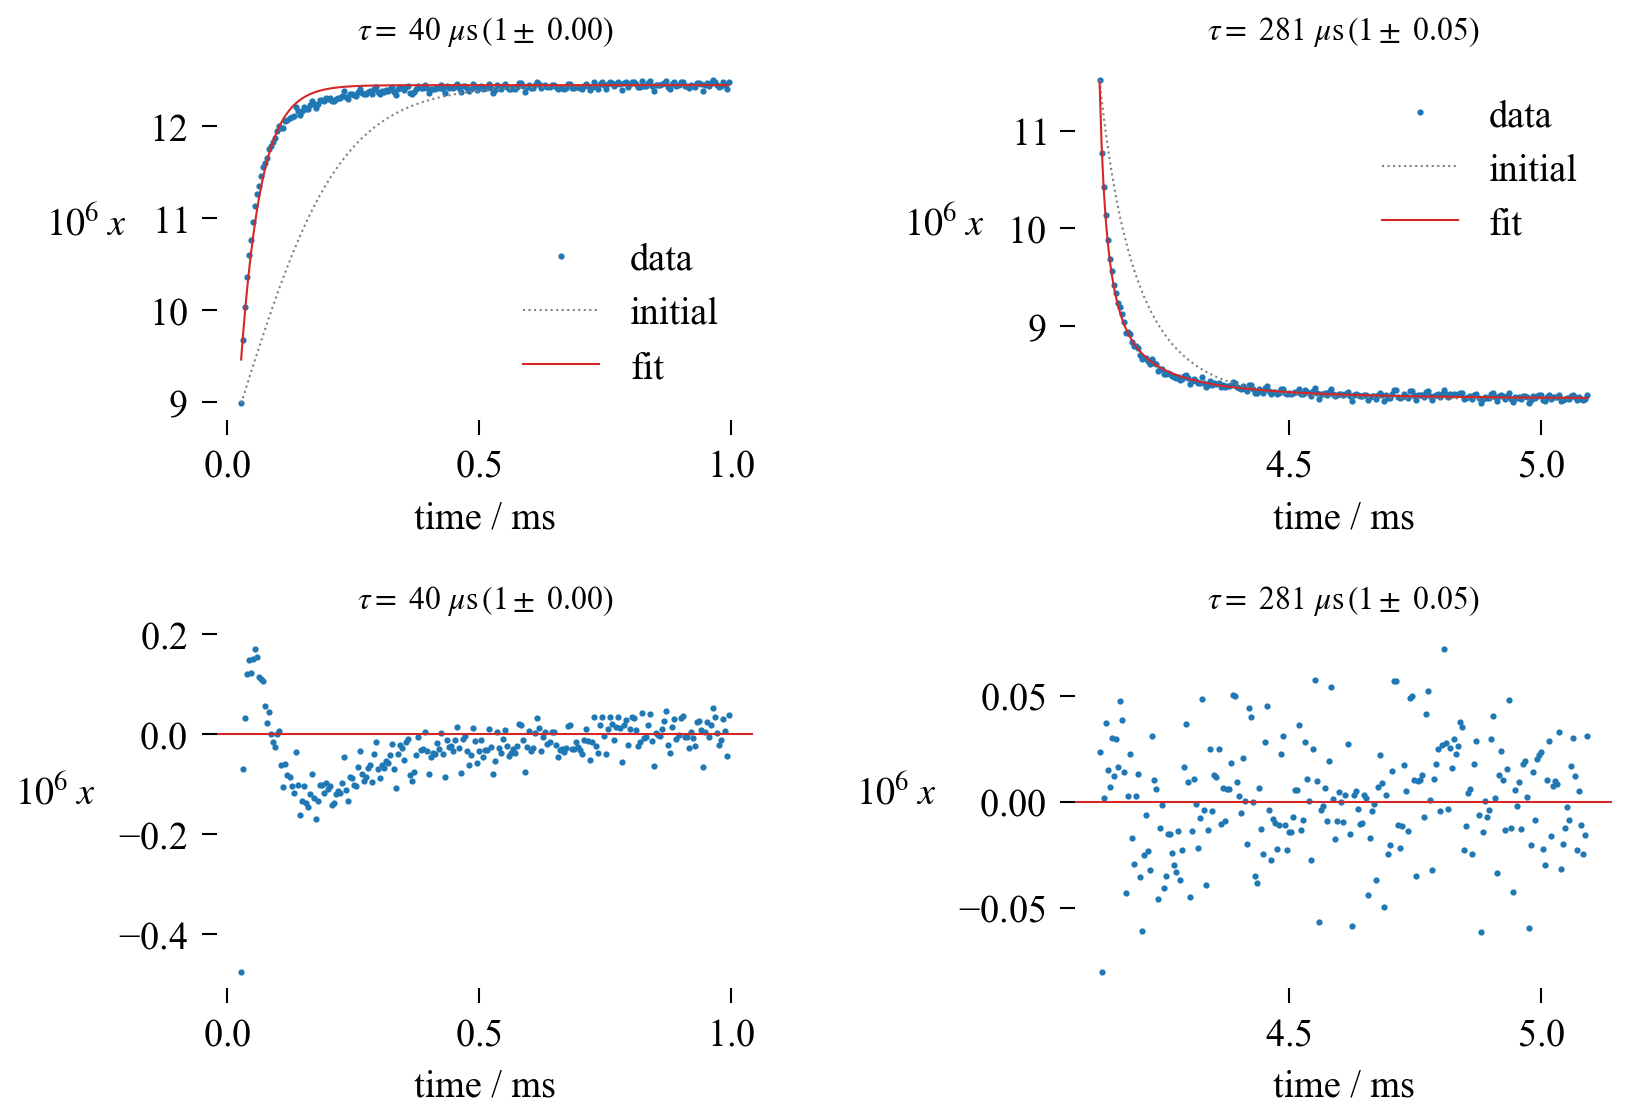

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4), gridspec_kw={'wspace': 0.6, 'hspace': 0.6})
(ax_rise, ax_fall), (ax_rise_residual, ax_fall_residual) = axes
plot_result(axis=ax_rise, time_fit=t_fit_rise, result=result_rise, initial=True)
plot_result(axis=ax_fall, time_fit=t_fit_fall, result=result_fall, initial=True)
plot_residual(axis=ax_rise_residual, time_fit=t_fit_rise, result=result_rise)
plot_residual(axis=ax_fall_residual, time_fit=t_fit_fall, result=result_fall)

#ax_rise.plot(time_scale * t_rise, x_scale * delta_x(t=t_rise, t0=t_rise[delay_samples], xbar=xbar, dx0=dx0,
#                             R_dn0=result_fall.values['R_dn0'], tau=result_fall.values['tau']),
#            color='C1')


In [36]:
result_rise.best_values

{'R_dn0_tau': -38.34093364397873,
 'dx0': -0.00027167486219426343,
 't0': -0.015524810612142162,
 'tau': 0.0001524633995782703,
 'xbar': 1.2449505e-05}

In [37]:
result_fall.best_values

{'R_dn0_tau': 6.5545340692504315,
 'dx0': 1.3022387878916483e-06,
 't0': 0.0041470885719001923,
 'tau': 0.00028073853522228944,
 'xbar': 8.2628085e-06}

(4.0470885719001917, 4.2470885719001927)

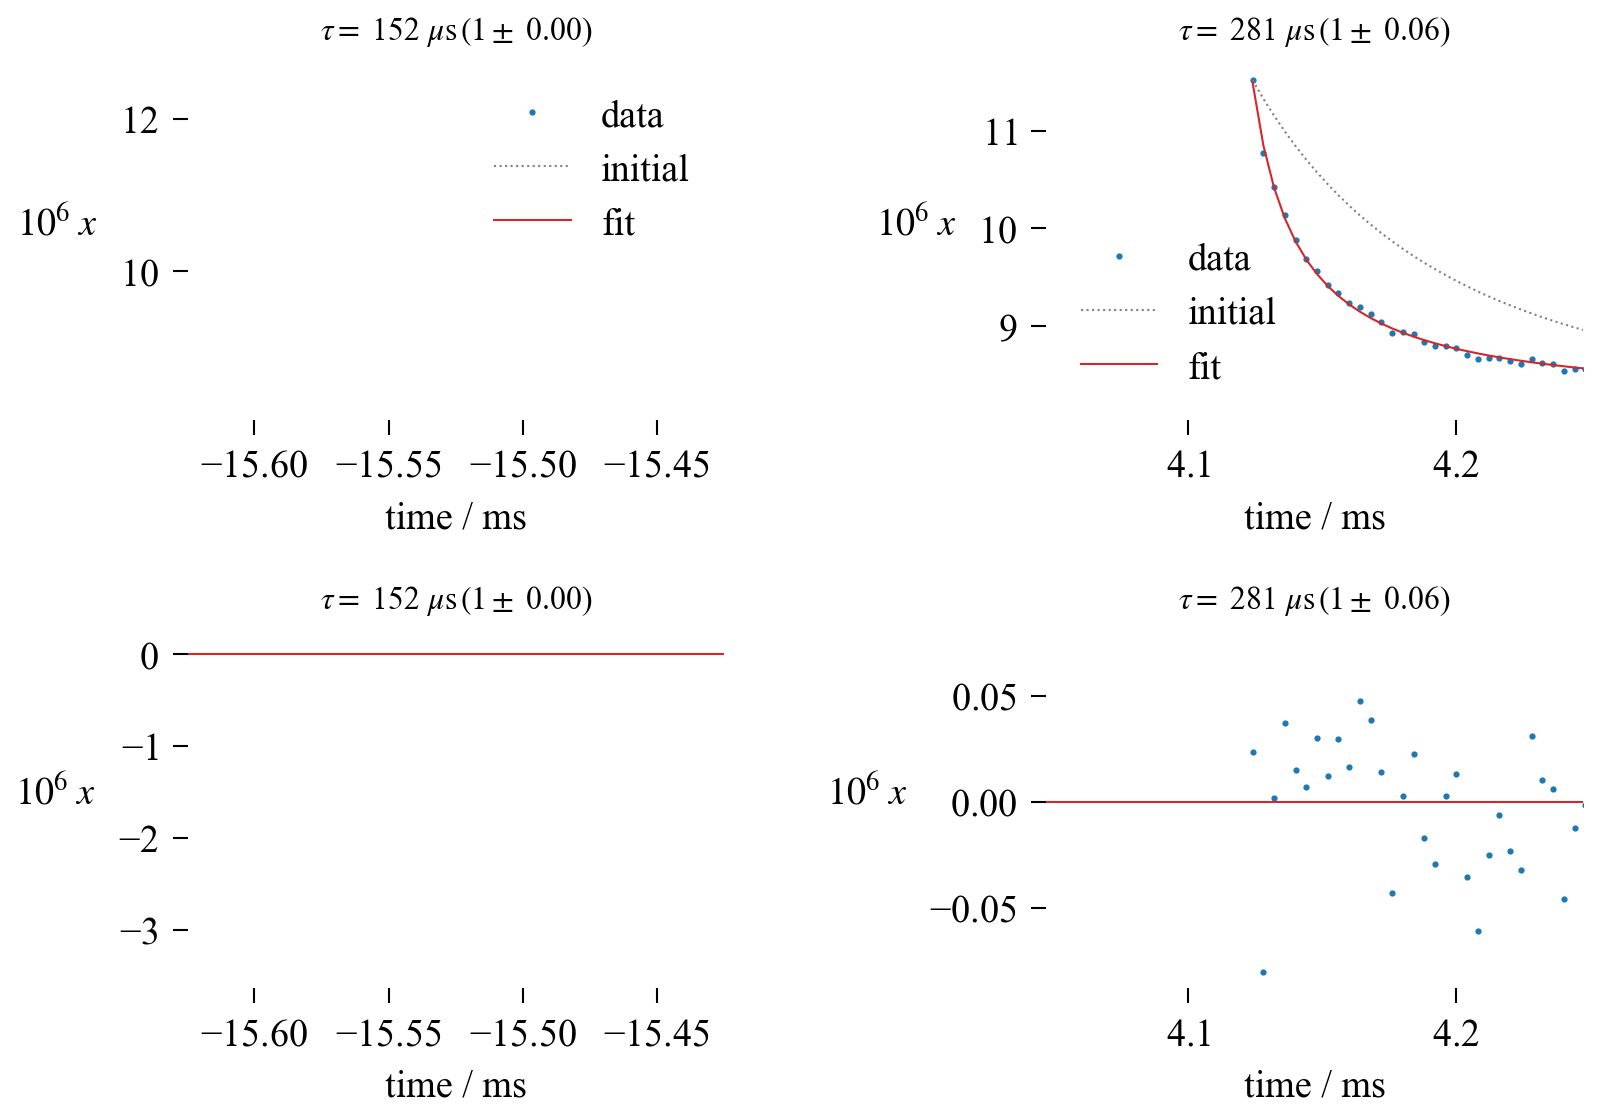

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4), gridspec_kw={'wspace': 0.6, 'hspace': 0.6})
(ax_rise, ax_fall), (ax_rise_residual, ax_fall_residual) = axes

ax_rise.plot(time_scale * time_fold_rise, x_scale * x_fold_rise, '.', color='gray')
plot_result(axis=ax_rise, time_fit=t_fit_rise, result=result_rise, initial=True)
plot_result(axis=ax_fall, time_fit=t_fit_fall, result=result_fall, initial=True)
plot_residual(axis=ax_rise_residual, time_fit=t_fit_rise, result=result_rise)
plot_residual(axis=ax_fall_residual, time_fit=t_fit_fall, result=result_fall)

dt = 0.1e-3
t0_rise = result_rise.best_values['t0']
t0_fall = result_fall.best_values['t0']
ax_rise.set_xlim(time_scale * (t0_rise - dt), time_scale * (t0_rise + dt))
ax_rise_residual.set_xlim(time_scale * (t0_rise - dt), time_scale * (t0_rise + dt))
ax_fall.set_xlim(time_scale * (t0_fall - dt), time_scale * (t0_fall + dt))
ax_fall_residual.set_xlim(time_scale * (t0_fall - dt), time_scale * (t0_fall + dt))


# Many free parameters

In [29]:
delta_x_model = lmfit.Model(delta_x)
#delta_x_model.independent_vars = ['']

NameError: name 'delta_x' is not defined

In [30]:
result_fall = delta_x_model.fit(x_fall, t=t_fall, t0=t_fall.min(), xbar=x_fall[-1],
                                dx0=x_fall[0] - x_fall[-1], R_tau_dn0=1, tau=0.0001)
tau_fall = result_fall.params['tau']
print(result_fall.fit_report())

NameError: name 'delta_x_model' is not defined

In [ ]:
result_rise = delta_x_model.fit(x_rise, t=t_rise, t0=t_rise.min(), xbar=x_rise[-1],
                                dx0=x_rise[0] - x_rise[-1], R_tau_dN0=1, tau=0.0001)
tau_rise = result_rise.params['tau']
print(result_rise.fit_report())

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('time / ms')
ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)

ax.plot(time_scale * t_fall,
        x_scale * x_fall,
        '.', color='C0', label='data')
#ax.plot(time_scale * t_fall,
#        x_scale * result_fall.init_fit,
#        ':', color='C1')
ax.plot(time_scale * t_fall,
        x_scale * result_fall.best_fit,
        '-', color='C3', label='fit')
ax.legend()
print('tau = {:.1f} +/- {:.1f} us'.format(1e6 * tau_fall.value, 1e6 * tau_fall.stderr))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('time / ms')
ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)

ax.plot(time_scale * t_rise,
        x_scale * x_rise,
        '.', color='C0', label='data')
#ax.plot(time_scale * t_rise,
#        x_scale * result_rise.init_fit,
#        ':', color='C1')
ax.plot(time_scale * t_rise,
        x_scale * result_rise.best_fit,
        '-', color='C3', label='fit')
ax.legend()
print('tau = {:.1f} +/- {:.1f} us'.format(1e6 * tau_rise.value, 1e6 * tau_rise.stderr))